# Tutorial 4: (extension) Query PAIRS for climate data in raster format

In this tutorial you will:  
1. Perform a raster query in PAIRS to retrieve temperature data
2. Plot the results spatially with Matplotlib

Full documentation and further PAIRS examples are available here: https://pairs.res.ibm.com/tutorial/tutorials/api/index.html

### The relevant data layers in PAIRS, and corresponding layer ids are:  
ERA5 temperature: id = 49423  
ERA5 rainfall: id = 49459  
CHIRPS rainfall: id = 49316  
Land cover (Copernicus): id = 30003  
NDVI (MODIS): id = 71  
JRC Global Surface Water: id = 517  
Global Population Density (SEDAC): id = 48774  

# Preparatory steps

### Set up Watson studio project token - replace this with a cell generated for your Watson Studio project

In [63]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.


### Install the PAIRS api library  

In [3]:
!pip install ibmpairs

     |████████████████████████████████| 43 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 3.8 MB/s eta 0:00:01
  Using cached futures-3.1.1-py3-none-any.whl (2.8 kB)
     |████████████████████████████████| 16.0 MB 4.1 MB/s eta 0:00:01
  Using cached Shapely-1.7.1-cp38-cp38-macosx_10_9_x86_64.whl (1.0 MB)
     |████████████████████████████████| 510 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 3.8 MB/s eta 0:00:01
Processing /Users/annejones/Library/Caches/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4/future-0.18.2-py3-none-any.whl
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)


### Load other required libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

### Connect to PAIRS - Watson Studio version
1. Copy the text string of your api key into a text file called "pairspass-<yourname>.txt"
    e.g. "pairspass-annejones.txt".  
      
2. Upload this file to your Watson Studio project assets: From the main project page, navigate to Assets -> Data assets. Click "New Data asset +". Drag and drop the file and wait for the upload to complete.  
3. Replace the file name and email address below with your file name and the email address you registered for PAIRS access.

In [4]:
from ibmpairs import paw, authentication
my_file = project.get_file("pairspass-annejones.txt") 
PAIRS_API_KEY=my_file.readline().decode('utf-8') 
PAIRS_USER = "anne.jones@ibm.com" # REPLACE WITH YOUR USERNAME
PAIRS_SERVER = "https://pairs.res.ibm.com"
OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY )

In [ ]:
### Connect to PAIRS - local version

In [7]:
# Local version
from ibmpairs import paw, authentication 
datadir = "/Users/annejones/"
with open(datadir + "/annejones-pairspass.txt") as my_file:
    PAIRS_API_KEY=my_file.readline()
PAIRS_USER = "anne.jones@ibm.com" # REPLACE WITH YOUR USERNAME
PAIRS_SERVER = "https://pairs.res.ibm.com"
OAUTH = authentication.OAuth2(api_key = PAIRS_API_KEY )

## PAIRS raster query

### Query PAIRS for a bounding box covering Vhembe district, Limpopo

In [12]:
latmin = -23.47
latmax = -22.15
lonmin = 28.92
lonmax = 31.11

id = 49423 # ERA 5 temperature

### Create query json for a bounding box, for one snapshot

In [13]:
query_json = {
    "layers" : [
        {"type" : "raster", "id" : id}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : [latmin, lonmin, latmax, lonmax]
    },
    "temporal" : {"intervals" : [
        {"snapshot" : "2015-05-31T00:00:00Z"}
    ]}
}

### For a raster query, data is not returned instantly so we have to wait (this example should only take a few minutes)

In [14]:
query = paw.PAIRSQuery(query_json, PAIRS_SERVER,  auth=OAUTH, authType='api-key')
query.submit()

### Refresh the cell below to monitor status of query

In [16]:
query.poll()
query.queryStatus.json()

{'id': '1623384000_15215820',
 'status': 'Succeeded',
 'start': 1623399215820,
 'folder': '1623399215820',
 'swLat': -23.469999,
 'swLon': 28.92,
 'neLat': -22.15,
 'neLon': 31.110001,
 'exPercent': 0.0,
 'flag': False,
 'hadoopId': '1602345287025_2998155',
 'ready': True,
 'rtStatus': 'Succeeded',
 'statusCode': 20}

### Retrieve the data

In [17]:
query.download()
query.create_layers()

GDAL is not available for proper GeoTiff loading, default to standard PIL module to load raster data.


### Get query metadata - this gives an id string which can be used to access metadata and the data itself

In [20]:
id_string = pd.DataFrame(query.metadata).transpose().index[0]
id_string

'Global weather (ERA5)-Temperature-05_31_2015T00_00_00'

In [44]:
id_string = pd.DataFrame(query.metadata).transpose().index[0]
data = query.data[id_string]

In [45]:
query.metadata[id_string]['details']

{'pixelType': 'fl',
 'pixelNoDataVal': -9999.0,
 'spatialRef': 'EPSG:4326',
 'boundingBox': {'minLatitude': -27.08544,
  'maxLatitude': -18.696832,
  'minLongitude': 25.520896,
  'maxLongitude': 33.909504},
 'pixelDimensions': {'pixelSizeDegreeLongitude': 0.131072,
  'pixelSizeDegreeLatitude': 0.131072,
  'numberPixelsLatitude': 64,
  'numberPixelsLongitude': 64},
 'rasterStatistics': {'pixelMin': 283.283142,
  'pixelMax': 289.991699,
  'pixelCount': 198,
  'pixelMean': 286.255294,
  'pixelStandardDeviation': 1.683487}}

### By default, PAIRS returns data with a border of empty cells. This function removes that border and corrects the metadata

In [59]:
def clean_pairs_raster(image, meta_data):
    bbox = meta_data['details']['boundingBox']
    y0 = bbox['minLatitude']
    x0 = bbox['minLongitude']
    
    res_y = meta_data['details']['pixelDimensions']['pixelSizeDegreeLatitude']
    res_x = meta_data['details']['pixelDimensions']['pixelSizeDegreeLongitude']

    # find first row and column with non missing data
    i = np.where(~np.isnan(image))
    rowfirst = min(i[0])
    rowlast = max(i[0])
    colfirst = min(i[1])
    collast = max(i[1])
    #print(rowfirst, rowlast, colfirst, collast)
    
    image_clean = image[rowfirst:(rowlast+1), colfirst:(collast+1)]
    ny = image_clean.shape[0]
    nx = image_clean.shape[1]
    x0 = x0 + res_x*colfirst
    y0 = y0 + res_y*rowfirst
    
    xmax = x0 + res_x*nx
    ymax = y0 + res_y*ny
    
    return image_clean, [y0, x0, ymax, xmax]

### Apply the function to the data array and also correct the bounding box from the metadata

In [60]:
cleaned_data, [y0, x0, ymax, xmax] = clean_pairs_raster(query.data[id_string], query.metadata[id_string])

### Plot using matplotlib

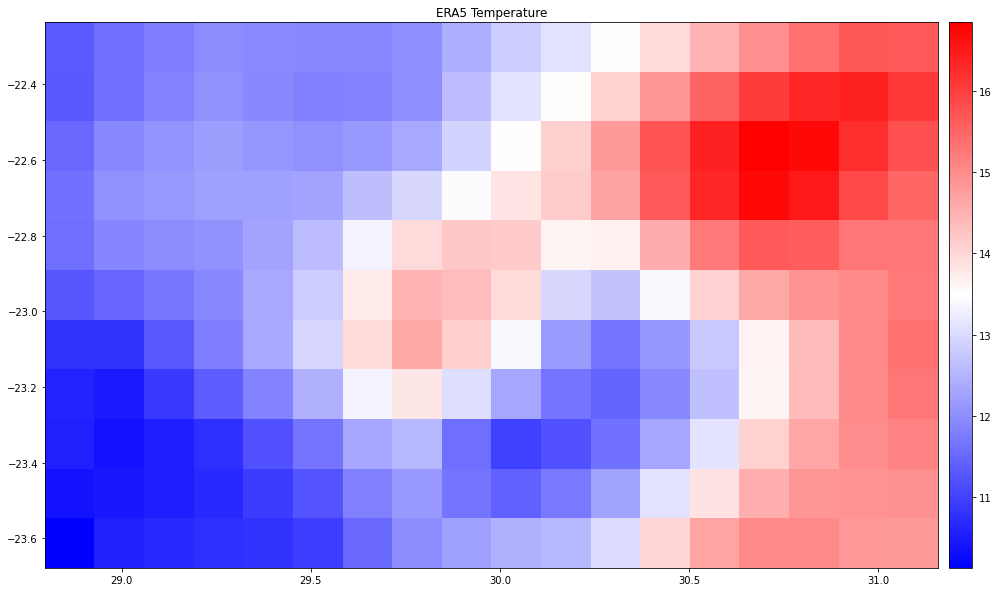

In [62]:
data_plot = cleaned_data - 273.15
extent = [x0, xmax, y0, ymax] 
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
plot = ax.imshow(data_plot, extent=extent, cmap="bwr")
ax.set_title("ERA5 Temperature")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(plot, cax=cax)
plt.show()

### Author and license

Anne Jones is a Research Staff Member at IBM Research, specialising in AI for Climate Risk and Impacts. 

Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.